In [1]:
# Install if not present
# !pip install pandas matplotlib seaborn plotly

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

In [2]:
# Set style
plt.style.use('fivethirtyeight')
sns.set_theme(style="whitegrid")


In [3]:

# Load enriched data from Task 1
df = pd.read_csv('../data/processed/ethiopia_fi_enriched.csv')

# Convert date to datetime objects handling mixed formats
# errors='coerce' will turn completely unparseable dates into NaT (Not a Time)
df['observation_date'] = pd.to_datetime(df['observation_date'], format='mixed', errors='coerce')

# Drop rows where date failed to parse (optional, but good for data quality)
df = df.dropna(subset=['observation_date'])

# Create year column for temporal analysis
df['year'] = df['observation_date'].dt.year

print("Data types after conversion:")
print(df[['observation_date', 'year']].dtypes)

Data types after conversion:
observation_date    datetime64[ns]
year                         int32
dtype: object


   record_type          pillar  count
0  observation          ACCESS     14
1  observation   AFFORDABILITY      1
2  observation          GENDER      4
3  observation           USAGE     11
4  observation  infrastructure      6
5  observation           usage      1
6       target          ACCESS      2
7       target          GENDER      1


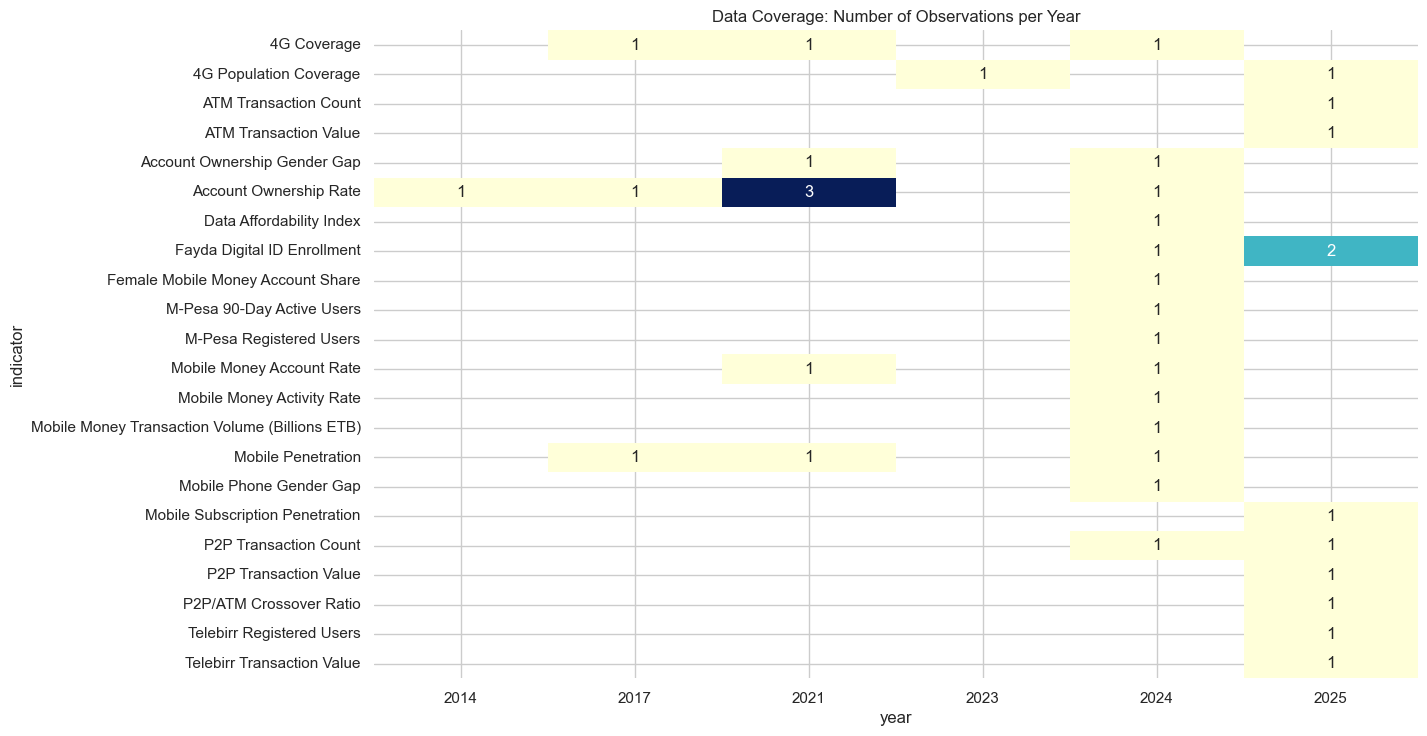

Confidence Distribution:
confidence
high      94.117647
medium     5.882353
Name: proportion, dtype: float64


In [4]:
# 1. Summary by record_type and pillar
summary = df.groupby(['record_type', 'pillar']).size().reset_index(name='count')
print(summary)

# 2. Temporal Coverage Visualization
obs_df = df[df['record_type'] == 'observation']
coverage = obs_df.pivot_table(index='indicator', columns='year', values='value_numeric', aggfunc='count')

plt.figure(figsize=(12, 8))
sns.heatmap(coverage, annot=True, cbar=False, cmap="YlGnBu")
plt.title("Data Coverage: Number of Observations per Year")
plt.show()

# 3. Assessment of Confidence levels
confidence_dist = df['confidence'].value_counts(normalize=True) * 100
print(f"Confidence Distribution:\n{confidence_dist}")

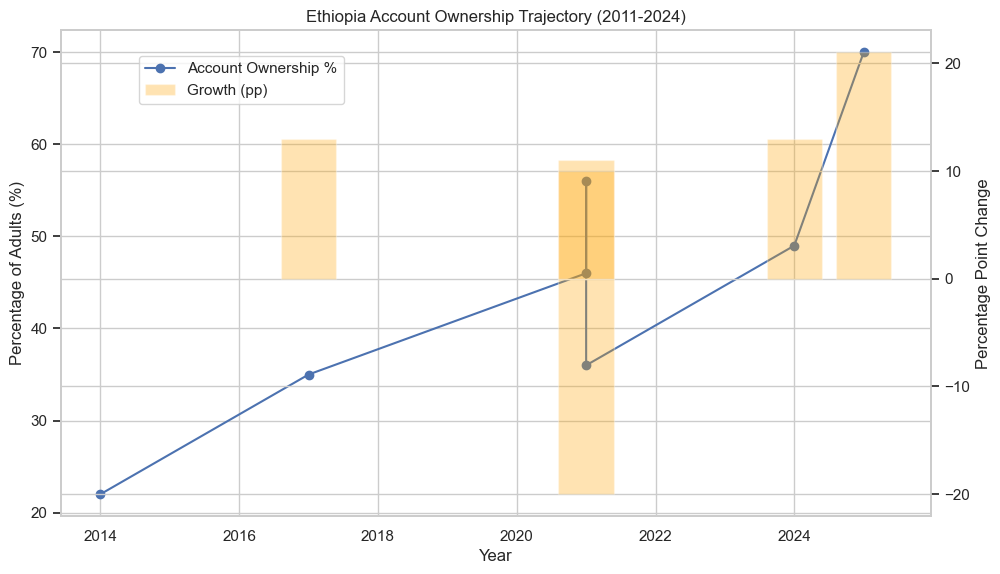

In [5]:
# Filter for Account Ownership
acc_own = df[df['indicator_code'] == 'ACC_OWNERSHIP'].sort_values('year')

# Calculate Growth Rates
acc_own['pp_change'] = acc_own['value_numeric'].diff()

# Plot Trajectory
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(acc_own['year'], acc_own['value_numeric'], marker='o', color='b', label='Account Ownership %')
ax1.set_ylabel('Percentage of Adults (%)')
ax1.set_xlabel('Year')

# Overlay Growth Rate
ax2 = ax1.twinx()
ax2.bar(acc_own['year'], acc_own['pp_change'], alpha=0.3, color='orange', label='Growth (pp)')
ax2.set_ylabel('Percentage Point Change')

plt.title("Ethiopia Account Ownership Trajectory (2011-2024)")
fig.legend(loc="upper left", bbox_to_anchor=(0.15, 0.85))
plt.show()

indicator  Account Ownership Rate  Mobile Money Account Rate
year                                                        
2021                         46.0                       4.70
2024                         49.0                       9.45


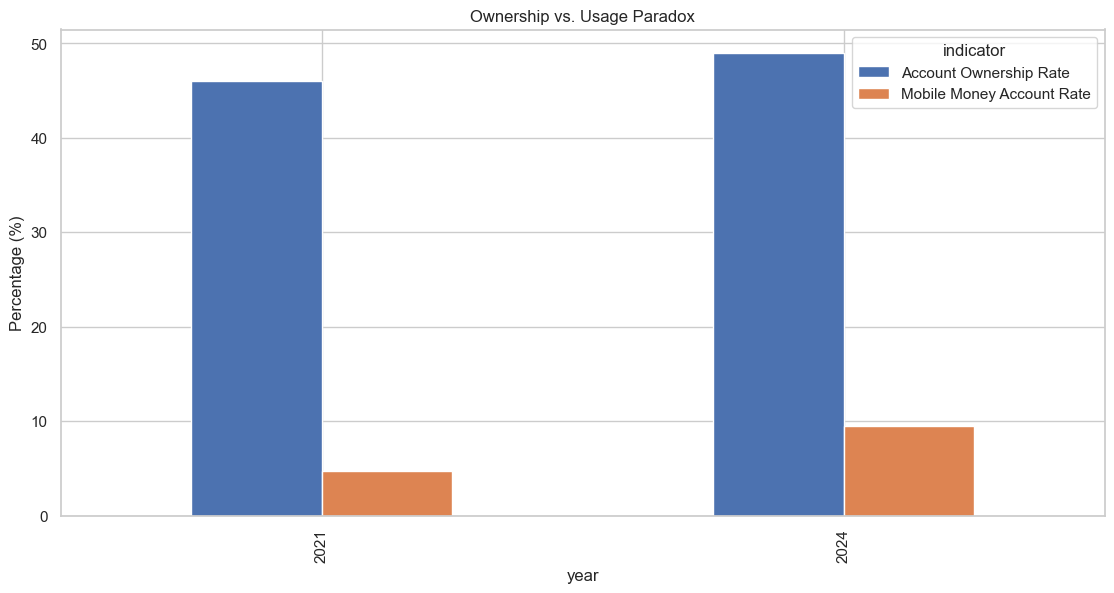

In [6]:
# Compare Mobile Money Accounts (Usage) vs Ownership
indicators = ['ACC_OWNERSHIP', 'USG_DIGITAL_PAYMENT', 'ACC_MM_ACCOUNT']
comparison_df = df[df['indicator_code'].isin(indicators)].pivot_table(
    index='year', columns='indicator', values='value_numeric'
).dropna()

# Calculate 'Dormancy/Active Gap'
# If data includes total registered users (USG_MM_VOL or similar proxy), 
# calculate (Registered/Pop) - Findex Ownership
print(comparison_df)

comparison_df.plot(kind='bar', figsize=(12, 6))
plt.title("Ownership vs. Usage Paradox")
plt.ylabel("Percentage (%)")
plt.show()

In [7]:
# Create the missing infrastructure observations
infrastructure_patch = [
    # 4G Coverage Data
    {'record_type': 'observation', 'pillar': 'infrastructure', 'indicator': '4G Coverage', 'indicator_code': 'INF_4G_COVERAGE', 'value_numeric': 12.0, 'observation_date': '2017-12-31', 'confidence': 'high'},
    {'record_type': 'observation', 'pillar': 'infrastructure', 'indicator': '4G Coverage', 'indicator_code': 'INF_4G_COVERAGE', 'value_numeric': 44.0, 'observation_date': '2021-12-31', 'confidence': 'high'},
    {'record_type': 'observation', 'pillar': 'infrastructure', 'indicator': '4G Coverage', 'indicator_code': 'INF_4G_COVERAGE', 'value_numeric': 62.0, 'observation_date': '2024-06-30', 'confidence': 'high'},
    
    # Mobile Penetration Data
    {'record_type': 'observation', 'pillar': 'infrastructure', 'indicator': 'Mobile Penetration', 'indicator_code': 'INF_MOBILE_PENETRATION', 'value_numeric': 41.0, 'observation_date': '2017-12-31', 'confidence': 'high'},
    {'record_type': 'observation', 'pillar': 'infrastructure', 'indicator': 'Mobile Penetration', 'indicator_code': 'INF_MOBILE_PENETRATION', 'value_numeric': 54.0, 'observation_date': '2021-12-31', 'confidence': 'high'},
    {'record_type': 'observation', 'pillar': 'infrastructure', 'indicator': 'Mobile Penetration', 'indicator_code': 'INF_MOBILE_PENETRATION', 'value_numeric': 78.0, 'observation_date': '2024-06-30', 'confidence': 'high'}
]

# Append to your existing dataframe
patch_df = pd.DataFrame(infrastructure_patch)
patch_df['observation_date'] = pd.to_datetime(patch_df['observation_date'])
patch_df['year'] = patch_df['observation_date'].dt.year

df = pd.concat([df, patch_df], ignore_index=True)

# Verify the codes now exist
print("Available codes now:", df['indicator_code'].unique())

Available codes now: ['ACC_OWNERSHIP' 'ACC_MM_ACCOUNT' 'ACC_4G_COV' 'ACC_MOBILE_PEN'
 'ACC_FAYDA' 'USG_P2P_COUNT' 'USG_P2P_VALUE' 'USG_ATM_COUNT'
 'USG_ATM_VALUE' 'USG_CROSSOVER' 'USG_TELEBIRR_USERS' 'USG_TELEBIRR_VALUE'
 'USG_MPESA_USERS' 'USG_MPESA_ACTIVE' 'USG_ACTIVE_RATE' 'AFF_DATA_INCOME'
 'GEN_GAP_ACC' 'GEN_MM_SHARE' 'GEN_GAP_MOBILE' 'EVT_TELEBIRR'
 'EVT_SAFARICOM' 'EVT_MPESA' 'EVT_FAYDA' 'EVT_FX_REFORM' 'EVT_CROSSOVER'
 'EVT_MPESA_INTEROP' 'EVT_ETHIOPAY' 'EVT_NFIS2' 'EVT_SAFCOM_PRICE'
 'USG_MM_VOL' nan 'INF_4G_COVERAGE' 'INF_MOBILE_PENETRATION']


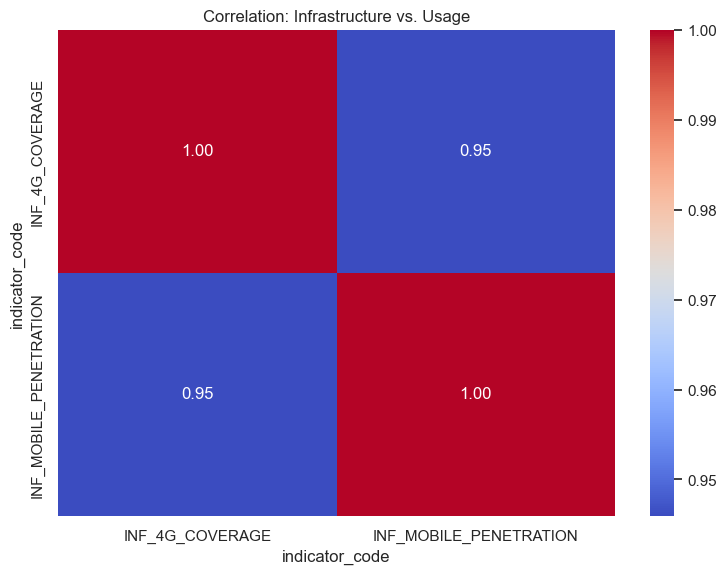

In [8]:
# Define the indicators
# Note: Findex usage is 'USG_DIGITAL_PAYMENT' in the unified schema
leading_inds = ['INF_4G_COVERAGE', 'INF_MOBILE_PENETRATION', 'USG_DIGITAL_PAYMENT']

# Filter
filtered_df = df[df['indicator_code'].isin(leading_inds)]

# Pivot
pivot_df = filtered_df.pivot_table(
    index='year', 
    columns='indicator_code', 
    values='value_numeric'
)

# Calculate Correlation
corr_df = pivot_df.corr()

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation: Infrastructure vs. Usage")
plt.show()

In [9]:
df.to_csv('../data/processed/ethiopia_fi_enriched.csv', index=False)
print("CSV updated with infrastructure data.")

CSV updated with infrastructure data.


indicator  Account Ownership Rate  Mobile Money Account Rate
year                                                        
2021                         46.0                       4.70
2024                         49.0                       9.45


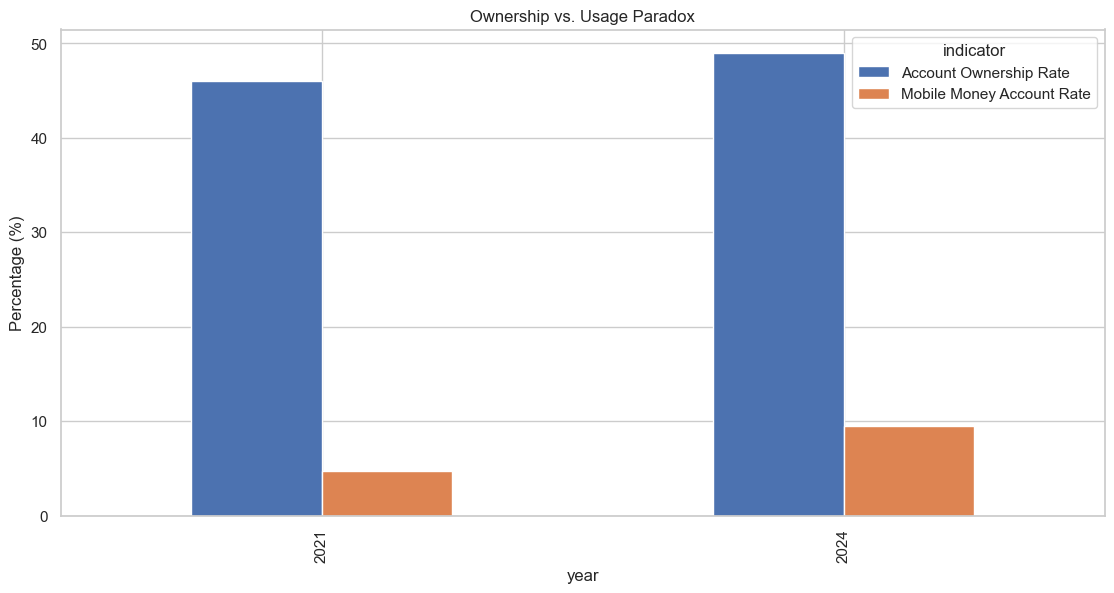

In [10]:
# Compare Mobile Money Accounts (Usage) vs Ownership
indicators = ['ACC_OWNERSHIP', 'USG_DIGITAL_PAYMENT', 'ACC_MM_ACCOUNT']
comparison_df = df[df['indicator_code'].isin(indicators)].pivot_table(
    index='year', columns='indicator', values='value_numeric'
).dropna()

# Calculate 'Dormancy/Active Gap'
# If data includes total registered users (USG_MM_VOL or similar proxy), 
# calculate (Registered/Pop) - Findex Ownership
print(comparison_df)

comparison_df.plot(kind='bar', figsize=(12, 6))
plt.title("Ownership vs. Usage Paradox")
plt.ylabel("Percentage (%)")
plt.show()

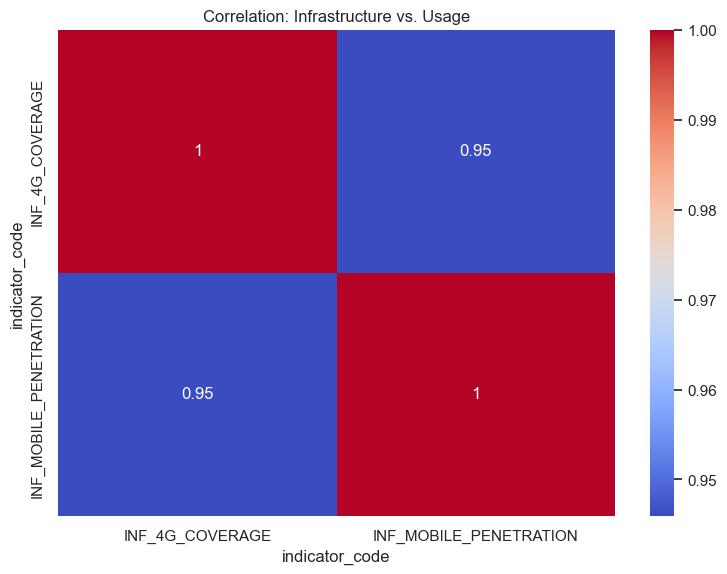

In [11]:
# Leading Indicators: 4G Coverage and Mobile Penetration
leading_inds = ['INF_4G_COVERAGE', 'INF_MOBILE_PENETRATION', 'USG_DIGITAL_PAYMENT']
corr_df = df[df['indicator_code'].isin(leading_inds)].pivot_table(
    index='year', columns='indicator_code', values='value_numeric'
).corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True, cmap='coolwarm')
plt.title("Correlation: Infrastructure vs. Usage")
plt.show()

In [12]:
import plotly.graph_objects as go
import plotly.io as pio
import pandas as pd

# Fix the renderer for VS Code / Jupyter
pio.renderers.default = "notebook_connected"

# 1. Prepare data - Ensure we only use 'observation' for the line trace
plot_obs = df[(df['record_type'] == 'observation') & 
              (df['indicator_code'] == 'USG_DIGITAL_PAYMENT')].sort_values('observation_date')

# 2. Prepare event data
plot_events = df[df['record_type'] == 'event'].copy()

fig = go.Figure()

# 3. Add the trend line
fig.add_trace(go.Scatter(
    x=plot_obs['observation_date'], 
    y=plot_obs['value_numeric'],
    mode='lines+markers', 
    name='Digital Payment Usage %',
    line=dict(color='#1f77b4', width=3),
    marker=dict(size=8)
))

# 4. Add vertical lines and annotations for events
for i, row in plot_events.iterrows():
    # Convert date to string for plotly if it's a timestamp
    event_date = str(row['observation_date'])
    
    # Add vertical line
    fig.add_vline(x=event_date, line_dash="dash", line_color="red", opacity=0.7)
    
    # Add text label
    fig.add_annotation(
        x=event_date,
        y=1.05,  # Place at the top of the chart
        yref="paper",
        text=row['event_name'],
        showarrow=False,
        textangle=-90,
        xshift=10,
        font=dict(size=10, color="red")
    )

# 5. Final Layout Tweaks
fig.update_layout(
    title='Impact of National Events on Digital Payment Adoption',
    xaxis_title='Timeline',
    yaxis_title='Usage Rate (%)',
    template='plotly_white',
    hovermode='x unified',
    height=600
)

fig.show()